# Wireless communication Assignment no.2 (Revised) 

# Introduction

![title](profile/group02_profile.jpg)

Hello, this is group no.2 form ET-E4 again!, We contains of three individuals who have worked on this revision of assigment no.2. In this revision we will try to resolve as many as possible things that are not right in the previous version. The assigment is: "The wireless transmission in which the data will be transmitted via AWGN channel and Rayleigh plus AWGN channel"

This work heavily based on Dacemo's Pyphysim, more detail can be found on https://github.com/darcamo/pyphysim

# Objective

In this notebook we will see how enviroment can affect our data transmitted wirelessly by adding the Additve White Gaussian Noise and Reyleigh fading to the transmitted data in order to simulate the real world enviroment.

We will used a JPEG picture as the transmit data, then retrive it at the reciever to see how data is affected when transmits wirelessly 

# Preparation

Before runing this notebook we need to install some dependencies

Install the pyphysim, and UI libaries:

In [ ]:
pip install pyphysim 

In [ ]:
pip install bitstring 

In [ ]:
pip install ipywidgets 

#### FOR WINDOWS 7 USER ONLY
Then if you are a WINDOWS 7 user like me you need to make some modification in the file:

In [ ]:
C:\Users\%username%\AppData\Local\Programs\Python\Python38\Lib\site-packages\pyphysim\util

 At line 12 you will see something like this, delete the ",np.float128" part then save it

In [ ]:
Serializable = Union[np.ndarray, np.int32, np.int64, np.float32, np.float64,
                     np.float128, set]

Since Windows 7 doesn't support float128 and we don't use it, deleting it will not beak anything 

# Implementation and theoretical backgroud
Wireless channels are characterized by fading, multipath, limited bandwidth, and frequency and time selectivity which make system design a challenge. It is neccessary to have an understanding of the behavior of wireless channels in order to know their performance limits and to be able to design more efficient communication systems.
##### In this note book, we will implement this model

![title](theory_pics/model.jpg)

## Modulation
One way to communicate a message signal whose frequency spectrum does not fall within that fixed frequency range,or one that is unsuitable for the channel, is to change a transmittable signal according to the information in the message signal.This alteration is called modulation, and it is the modulated signal that is transmitted. The receiver then recovers the original  signal through a process called demodulation. 
 There are various types of modulating schemes involves in the communication system like Phase shift keying(PSK), Frequency shift keying(FSK), Minimum shift keying(MSK), Quadrature phase shift keying(QPSK), Quadrature amplitude modulation(QAM) and  Differential Phase Shift Keying (DPSK)
 
 #### 1. Binary Phase Shift Keying (BPSK)
 
 **BPSK** uses two phases which are separated by 180° and so can also be termed 2-PSK. It does not particularly matter exactly where the constellation points are positioned. This modulation technique is the most robust of all PSKs since it takes the highest level of noise or distortion to make the demodulator reach an incorrect decision.
 
**In this notebook we only use BPSK modulation, since the data we are going to simmulate the transmission is already in binary, it easier to send the bitstream directly without additional processing steps (like with QPSK, take every 2 bits and covert it to integer). However, we will try to implement it in very near future.**


####  2. Signal to Noise Ratio (SNR)
 
Signal to noise ratio (SNR) is an indicator commonly used to evaluate the quality of a communication link and measured in decibels and represented by equation.
**SNR  =  10  log10 (Signal  Power  / Noise  Power)  dB**

The  performance of data transmission  over  wireless channels is well captured by observing their BER, which is a function of Signal to Noise Ratio (SNR) at the receiver.BER is inversely related to SNR, that is high BER causes low SNR. High BER causes increases packet loss, increase in delay and decreases throughput In wireless channels, several models have been proposed and investigated to calculate SNR.

Plot of SNR vs BER in multi fading channels is shown below:
![title](theory_pics/BERSNRmultifading.jpg)

All the models are a function of the distance between the sender and the receiver, the path loss exponent and the channel gain. Several probability distributed functions are available to model a time-variant parameter i.e. channel gain. We describe the three important and  frequently used distributions. Those are Additive White Gaussian Noise (AWGN) and Rayleigh.

####  3. Peak signal-to-noise ratio (PSNR)
PSNR is most commonly used to measure the quality of reconstruction of lossy compression codec. The signal in this case is the original data, and the noise is the error introduced by compression. When comparing compression codecs, PSNR is an approximation to human perception of reconstruction quality.

PSNR is most easily defined via the mean squared error (MSE). Given a noise-free m×n monochrome image I and its noisy approximation K, MSE is defined as:

![title](theory_pics/3a34719b4f391dba26b3e8e4460b7595d62eece4.svg)

![title](theory_pics/fc22801ed1232ff1231c4156b589de5c32063a8a.svg)

Typical values for the PSNR in lossy image and video compression are between 30 and 50 dB, provided the bit depth is 8 bits, where higher is better. With JPEG compression of image, 

# Transmission with AWGN channel implementation
 AWGN channel is not a fading channel.
  In low SNR, white Gaussian noise dominate the BER error, which can be improved by enhancing SNR. Thus, BER performance is
worse in flat fading channel and frequency selective fading channel, but best in AWGN channel. 

![title](theory_pics/SNR_AWGN.jpg)

As mention earlier, we will implement a jpeg image transmission, this is the image we are using
![title](JPG_image/img1.jpg)

First we import the nescessary libary and functions

In [ ]:
%matplotlib inline

import math
import cv2

import numpy as np
from matplotlib import pyplot as plt

from pyphysim.modulators.fundamental import BPSK, QAM, QPSK, Modulator
from pyphysim.simulations import Result, SimulationResults, SimulationRunner
from pyphysim.util.conversion import dB2Linear
from pyphysim.util.misc import pretty_time, randn_c

from IPython.display import Image,display

np.set_printoptions(precision=2, linewidth=120)

modulation="BPSK"

We begin at the Transmitter side, here the data will be read from the image, modulate and send it

First we draw the BPSK constellation

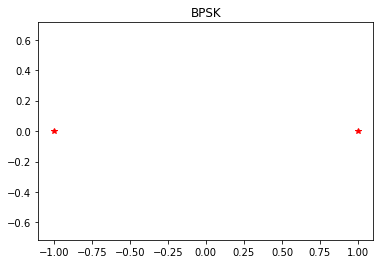

In [6]:
def draw_const():
    bpsk = BPSK()
    fig, ax = plt.subplots()
    ax.set_title("BPSK")
    ax.plot(bpsk.symbols.real, bpsk.symbols.imag, "*r", label="BPSK")
    ax.axis("equal")
    plt.show()
draw_const()

Then we open the JPEG image file and conver it into bitstream, here are the image we are going to send

In [7]:
from bitstring import BitArray
with open('JPG_image/img1.jpg', mode='rb') as file: # b is important -> binary
    fileContent = file.read()

k = BitArray(bytes=fileContent).bin
data = np.array(list(k),dtype=int)
num_symbols = len(data)
print(data)

[1 1 1 ... 0 0 1]


Then the data is being modulated

In [8]:
bpsk = BPSK()
modulated_data_bpsk = bpsk.modulate(data)

The Data is being sent.At this point we already done with the Transmitter

While the Data is in the air, let's add some noise to replicate the real world enviroment.At this point only AWGN is present

We start with geneate some random nosie

In [9]:
def generate_AWGN(SNR_dB):
    print(SNR_dB)
    snr_linear = dB2Linear(SNR_dB)
    noise_power = 1 / snr_linear
    print(num_symbols)
    # Noise vector
    n = math.sqrt(noise_power) * randn_c(num_symbols)
    return n
n = generate_AWGN(10)


10
441392


Then add it to the signal in the air

In [10]:
received_data_bpsk = modulated_data_bpsk + n

This is when the receiver receive the signal

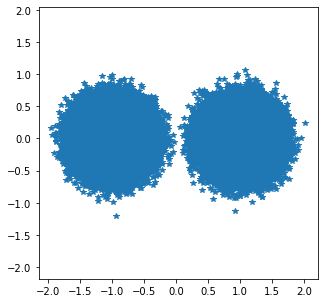

In [11]:
def draw_error():
    # Received data
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(received_data_bpsk.real, received_data_bpsk.imag, "*")
    ax.axis("equal")
draw_error()

This is the recived signal's error value

Demodulate the signal, and got back our bitstream

In [12]:
demodulated_data_bpsk = bpsk.demodulate(received_data_bpsk)
print(demodulated_data_bpsk)

[1 1 1 ... 0 0 1]


Calculate the number of error bit and bit error rate

In [13]:
def err_rate():
    err_bits =num_symbols- (np.count_nonzero(demodulated_data_bpsk==data))
    BER = err_bits/num_symbols
    print('BER: ',BER,'number of error bits: ', err_bits, '/', num_symbols)
err_rate()

BER:  0.0 number of error bits:  0 / 441392


Then the bistream are converted to bytes and repackage to be a jpeg image

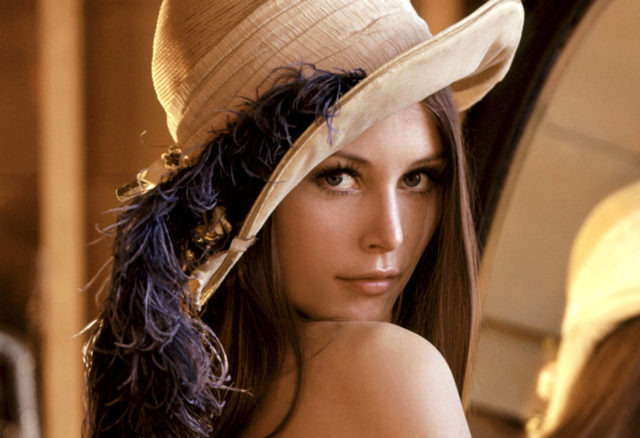

In [14]:
def repack_file(output_file):
    import itertools
    bt =bytearray( [sum([byte[b] << b for b in range(0,8)])
                for byte in zip(*
                    [itertools.islice(demodulated_data_bpsk, i, None, 8) for i in reversed(range(0,8))]
                )
            ])
    with open(output_file, "wb") as out_file:
        out_file.write(bt)
        
    display(Image(filename=output_file))

repack_file('JPG_image/img2.jpg')

The result at the receiver we have

This is the result of one of the previous run of this simulation at SNR = 10
![title](JPG_image/img2_10.jpg)

### Calculate PSNR

In [15]:
def get_psnr(p1,p2):
    img1 = cv2.imread(p1)
    img2 = cv2.imread(p2)
    try:
        psnr = cv2.PSNR(img1, img2)
        print('PSNR :',psnr)
    except:
        psnr=-1
        print('Image is too corrupted to calculate PSNR')
    return psnr

get_psnr('JPG_image/img1.jpg','JPG_image/img2.jpg')

PSNR : 361.20199909921956


361.20199909921956

# Transmission with Reyleigh and AWGN channel

Rayleigh  fading  is  most  applicable  when there is no dominant propagation along a line of sight (LOS) between transmitter and receiver.
The Rayleigh fading channnel refers to a multiplicative distortion h(t) of transmitted signal s(t) and received waveform and the noise as, **y (t) = h (t) {s (t) + n (t)}** y (t) is the received waveform and n is the noise.

![title](theory_pics/BPSK_Rayleigh_AWGN_SNR_BER.jpg)


#### Compare with the same binary error rate, Rayleigh channel supports **high** SNR than AWGN channel . The modeling of the multipath fading channel based on the Rayleigh channel modeling and it gives the similar performance. 


Implemetation wise we will reuse and recall most of the functions in the previous part to keep this part abtract, and we continue with the signal right after the data is transmitted. Therefore we start with the part where our signal is in the air

We generate AWGN

In [16]:
del received_data_bpsk,demodulated_data_bpsk

Also add the Reyleigh fading

In [17]:
def gen_Rayleigh(SNR):
    h = randn_c(modulated_data_bpsk.size)
    # Receive the corrupted data
    received_data_bpsk = h * modulated_data_bpsk + generate_AWGN(SNR)
    # Equalization
    received_data_bpsk /= h
    return received_data_bpsk
received_data_bpsk = gen_Rayleigh(30)

30
441392


Then at the receiver we repeat the same procedure as previous part

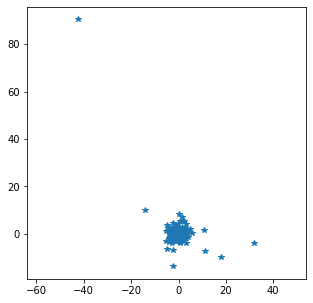

In [18]:
draw_error()

We can see the error value with the Rayleigh is quite differnet

In [19]:
demodulated_data_bpsk = bpsk.demodulate(received_data_bpsk)
print(demodulated_data_bpsk)

[1 1 1 ... 0 0 1]


In [20]:
repack_file('JPG_image/img2_rayleigh.jpg')

This is the result
<!-- ![title](img2_rayleigh.jpg) -->

This is the result of one of the previous run of this simulation at SNR = 30
![title](JPG_image/img2_releg_30.jpg)

### Calculating PSNR

In [21]:
get_psnr('JPG_image/img1.jpg','JPG_image/img2_rayleigh.jpg')

PSNR : 10.482195405581496


Corrupt JPEG data: premature end of data segment


10.482195405581496

## Playing with different parameters

In [ ]:
from ipywidgets import interact
def simulation(SNR,Mode):
    global received_data_bpsk, demodulated_data_bpsk
    if(Mode == 'AWGN'):
        received_data_bpsk = modulated_data_bpsk + generate_AWGN(SNR)
    elif (Mode == 'AWGN with Rayleigh') :
        received_data_bpsk = gen_Rayleigh(SNR)
    draw_error()
    demodulated_data_bpsk = bpsk.demodulate(received_data_bpsk)
    err_bits =num_symbols- (np.count_nonzero(demodulated_data_bpsk==data))
    BER = err_bits/num_symbols
    print('BER: ',BER,'number of error bits: ', err_bits, '/', num_symbols)
    repack_file('JPG_image/img4.jpg')
    get_psnr('JPG_image/img1.jpg','JPG_image/img4.jpg') 

    # print('PSNR : ', get_psnr('img1.jpg','img4.jpg') if get_psnr('img1.jpg','img4.jpg') != -1 else 'error image is too corrupted')
    return

# del received_data_bpsk,demodulated_data_bpsk
modes = ['AWGN', 'AWGN with Rayleigh']
interact(simulation,SNR=20,Mode=modes)


interactive(children=(IntSlider(value=20, description='SNR', max=60, min=-20), Dropdown(description='Mode', op…

<function __main__.simulation(SNR, Mode)>

# Conclusion

From this simulation we can se how the Gaussian noise and Rayleigh fading has affected the transmission of a wirelessly channel by the simulation of transmitting with the JPEG image has corrupted at the receiver, and evaluate it with PSNR, for image quality evaluation 